# Seqeunce Model with Attention for Addition Learning

- Use seq-to-seq model to learn mathematical addition based on data
- This is based on Chapter 7 of [Deep Learning 2用 Python 進行自然語言處理的基礎理論實作](https://www.tenlong.com.tw/products/9789865020675).
- This notebook uses two types of Attention layers:
  - The first type is the default `keras.layers.Attention` (Luong attention) and `keras.layers.AdditiveAttention` (Bahdanau attention). (But these layers have ONLY been implemented in Tensorflow-nightly.
  - The second type is developed by Thushan.
    - Bahdanau Attention Layber developed in [Thushan](https://github.com/thushv89/attention_keras)
    - Thushan Ganegedara's
    [Attention in Deep Networks with Keras](https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39)

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import os
os.chdir('/content/drive/My Drive/_MySyncDrive/Repository/python-notes/nlp')

In [59]:
%pwd

'/content/drive/My Drive/_MySyncDrive/Repository/python-notes/nlp'

In [60]:
!pip install tf-nightly

In [61]:
import tensorflow, keras
print(tensorflow.__version__)
print(keras.__version__)

2.5.0-dev20201029
2.4.3


## Functions

In [62]:
import re
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Dense, GRU
from tensorflow.keras.layers import AdditiveAttention, Attention
import numpy as np
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras import Model
from keras.models import Sequential
from keras.layers import LSTM, GRU, Concatenate
from keras.layers import Attention
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras import Input
from attention import AttentionLayer
from keras.utils import to_categorical


# Path to the data txt file on disk.
def get_data(data_path, train_test = 0.9):
    data_path = '../../../RepositoryData/data/deep-learning-2/addition.txt'
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')

    enc_text=[l.split('_')[0] for l in lines]
    dec_text=[l.split('_')[-1].strip() for l in lines]

    dec_text = ['_' + sent + '_' for sent in dec_text]
    
    np.random.seed(123)
    inds = np.arange(len(enc_text))
    np.random.shuffle(inds)
        
    train_size = int(round(len(lines)*train_test))
    train_inds = inds[:train_size]
    test_inds = inds[train_size:]
    tr_enc_text = [enc_text[ti] for ti in train_inds]
    tr_dec_text = [dec_text[ti] for ti in train_inds]

    ts_enc_text = [enc_text[ti] for ti in test_inds]
    ts_dec_text = [dec_text[ti] for ti in test_inds]
    
    return tr_enc_text, tr_dec_text, ts_enc_text, ts_dec_text


## when the max_len is known, use this func to convert text to seq
def sents2sequences(tokenizer, sentences, reverse=False, pad_length=None, padding_type='post'):
    encoded_text = tokenizer.texts_to_sequences(sentences)
    preproc_text = pad_sequences(encoded_text, padding=padding_type, maxlen=pad_length)
    if reverse:
        preproc_text = np.flip(preproc_text, axis=1)
    return preproc_text



def preprocess_data(enc_tokenizer, dec_tokenizer, enc_text, dec_text):
    enc_seq = enc_tokenizer.texts_to_sequences(tr_enc_text)
    enc_timesteps = np.max([len(l) for l in enc_seq])
    enc_seq = pad_sequences(enc_seq, padding='post', maxlen = enc_timesteps)
    dec_seq = dec_tokenizer.texts_to_sequences(tr_dec_text)
    dec_timesteps = np.max([len(l) for l in dec_seq])
    dec_seq = pad_sequences(dec_seq, padding='post', maxlen = dec_timesteps)
    return enc_seq, dec_seq

In [63]:
def define_nmt(hidden_size, batch_size, enc_timesteps, enc_vsize, dec_timesteps, dec_vsize):
    """ Defining a NMT model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inputs')
        decoder_inputs = Input(batch_shape=(batch_size, dec_timesteps - 1, dec_vsize), name='decoder_inputs')
    else:
        encoder_inputs = Input(shape=(enc_timesteps, enc_vsize), name='encoder_inputs')
        if fr_timesteps:
            decoder_inputs = Input(shape=(dec_timesteps - 1, dec_vsize), name='decoder_inputs')
        else:
            decoder_inputs = Input(shape=(None, dec_vsize), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
    encoder_out, encoder_state = encoder_gru(encoder_inputs)

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
    decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

    # Attention layer
    # attn_layer = AttentionLayer(name='attention_layer')
    attn_layer = AdditiveAttention(name="attention_layer")

    ## The input for AdditiveAttention: query, key
    ## It returns a tensor of shape as query
    ## This is different from the AttentionLayer developed by Thushan
    # attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    attn_out, attn_states  = attn_layer([decoder_out,encoder_out],return_attention_scores=True)

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    dense = Dense(dec_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    full_model.summary()

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inf_inputs')
    encoder_inf_out, encoder_inf_state = encoder_gru(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_state])

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, dec_vsize), name='decoder_word_inputs')
    encoder_inf_states = Input(batch_shape=(batch_size, enc_timesteps, hidden_size), name='encoder_inf_states')
    decoder_init_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_init')

    decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
    # attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    attn_inf_out, attn_inf_states  = attn_layer([decoder_inf_out, encoder_inf_states],return_attention_scores=True)

    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

    return full_model, encoder_model, decoder_model

def train(full_model, enc_seq, dec_seq, batch_size, n_epochs=10):
    """ Training the model """
    loss_epoch = []
    accuracy_epoch = []
    for ep in range(n_epochs):
        losses = []
        accuracies = []
        for bi in range(0, enc_seq.shape[0] - batch_size, batch_size):

            enc_onehot_seq = to_categorical(
                enc_seq[bi:bi + batch_size, :], num_classes=enc_vsize)
            dec_onehot_seq = to_categorical(
                dec_seq[bi:bi + batch_size, :], num_classes=dec_vsize)

            full_model.train_on_batch(
                [enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :])

            l,a = full_model.evaluate([enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :],
                                    batch_size=batch_size, verbose=0)

            losses.append(l)
            accuracies.append(a)
        if (ep + 1) % 1 == 0:
            print("Loss/Accuracy in epoch {}: {}/{}".format(ep + 1, np.mean(losses), np.mean(accuracies)))
            loss_epoch.append(np.mean(losses))
            accuracy_epoch.append(np.mean(accuracies))
    return loss_epoch, accuracy_epoch


def infer_nmt(encoder_model, decoder_model, test_enc_seq, enc_vsize, dec_vsize, dec_timesteps):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_en_seq: sequence of word ids
    :param en_vsize: int
    :param fr_vsize: int
    :return:
    """

    test_dec_seq = sents2sequences(dec_tokenizer, ['_'], dec_vsize)
    test_enc_onehot_seq = to_categorical(test_enc_seq, num_classes=enc_vsize)
    test_dec_onehot_seq = np.expand_dims(
        to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

    enc_outs, enc_last_state = encoder_model.predict(test_enc_onehot_seq)
    dec_state = enc_last_state
    attention_weights = []
    dec_text = ''
    for i in range(dec_timesteps):

        dec_out, attention, dec_state = decoder_model.predict(
            [enc_outs, dec_state, test_dec_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break
        test_dec_seq = sents2sequences(
            dec_tokenizer, [dec_index2word[dec_ind]], dec_vsize)
        test_dec_onehot_seq = np.expand_dims(
            to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

        attention_weights.append((dec_ind, attention))
        dec_text += dec_index2word[dec_ind]

    return dec_text, attention_weights


In [64]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=["PingFang HK"]
def plot_attention_weights(encoder_inputs, attention_weights, enc_id2word, dec_id2word, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
    attention_mat = np.transpose(np.array(mats))

    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels([dec_id2word[inp] if inp != 0 else "<Res>" for inp in dec_inputs])
    ax.set_yticklabels([enc_id2word[inp] if inp != 0 else "<Res>" for inp in encoder_inputs.ravel()])

    ax.tick_params(labelsize=32)
    ax.tick_params(axis='x', labelrotation=90)

#     if not os.path.exists(config.RESULTS_DIR):
#         os.mkdir(config.RESULTS_DIR)
#     if filename is None:
#         plt.savefig( 'attention.png'))
#     else:
#         plt.savefig(os.path.join(config.RESULTS_DIR, '{}'.format(filename)))

## Main Program

### Data Wrangling and Training

In [65]:
#### hyperparameters
batch_size = 128
hidden_size = 256
n_epochs = 50

### Get data
tr_enc_text, tr_dec_text, ts_enc_text, ts_dec_text = get_data(data_path='../../../RepositoryData/data/deep-learning-2/addition.txt')

# """ Defining tokenizers """
enc_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK', char_level=True)
enc_tokenizer.fit_on_texts(tr_enc_text)

dec_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK', char_level=True)
dec_tokenizer.fit_on_texts(tr_dec_text)

# ### Getting sequence integer data
enc_seq, dec_seq = preprocess_data(enc_tokenizer, dec_tokenizer, tr_enc_text, tr_dec_text)

# ### timestesps
enc_timesteps = enc_seq.shape[1]
dec_timesteps = dec_seq.shape[1]

# ### vocab size
enc_vsize = max(enc_tokenizer.index_word.keys()) + 1
dec_vsize = max(dec_tokenizer.index_word.keys()) + 1






In [66]:
print(enc_vsize)
print(dec_vsize)
print(tr_enc_text[:5])
print(tr_dec_text[:5])

14
13
['27+673 ', '153+27 ', '93+901 ', '243+678', '269+46 ']
['_700_', '_180_', '_994_', '_921_', '_315_']


In [67]:
###""" Defining the full model """
full_model, infer_enc_model, infer_dec_model = define_nmt(
    hidden_size=hidden_size,
    batch_size=batch_size,
    enc_timesteps=enc_timesteps,
    dec_timesteps=dec_timesteps,
    enc_vsize=enc_vsize,
    dec_vsize=dec_vsize)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(128, 7, 14)]       0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(128, 5, 13)]       0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(128, 7, 256), (128 208896      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(128, 5, 256), (128 208128      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

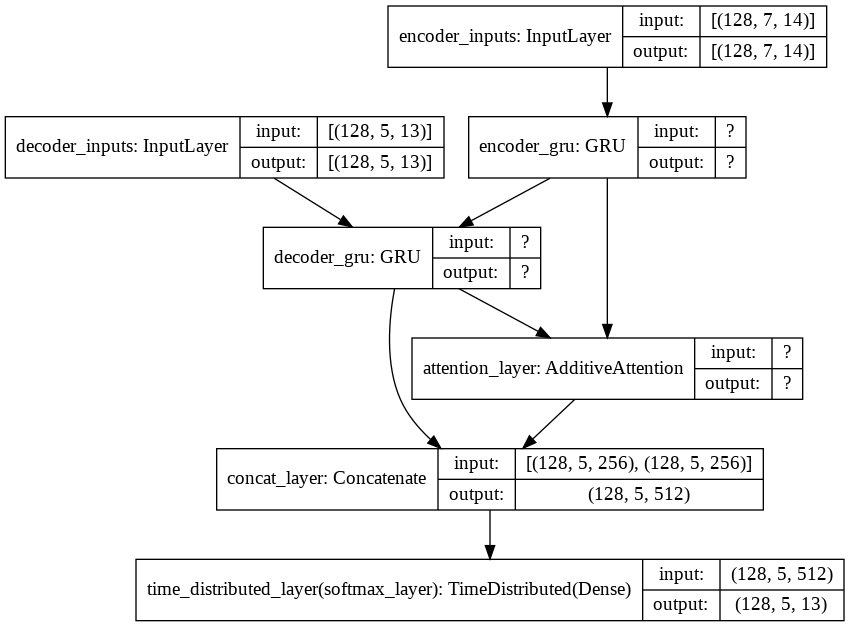

In [68]:
from keras.utils import plot_model
plot_model(full_model, show_shapes=True)

In [69]:
%%time
loss, accuracy = train(full_model, enc_seq, dec_seq, batch_size, n_epochs)

Loss/Accuracy in epoch 1: 1.466877539952596/0.4631009607912808
Loss/Accuracy in epoch 2: 1.2697382407989937/0.5272079769023124
Loss/Accuracy in epoch 3: 1.044164922332492/0.6073628906850461
Loss/Accuracy in epoch 4: 0.9069581612562522/0.660710469949619
Loss/Accuracy in epoch 5: 0.7824556773204749/0.707051280217293
Loss/Accuracy in epoch 6: 0.6974543691360713/0.7420272439972967
Loss/Accuracy in epoch 7: 0.6336102271691347/0.7654691960057641
Loss/Accuracy in epoch 8: 0.5783972347903455/0.7827590814343205
Loss/Accuracy in epoch 9: 0.5278063926771496/0.799149751663208
Loss/Accuracy in epoch 10: 0.4793944070991288/0.8159989307069371
Loss/Accuracy in epoch 11: 0.4336995489237315/0.8327946934604916
Loss/Accuracy in epoch 12: 0.38870076491282535/0.8496527773702246
Loss/Accuracy in epoch 13: 0.33074596914810334/0.8746616797909098
Loss/Accuracy in epoch 14: 0.2669906813194949/0.9021768145411783
Loss/Accuracy in epoch 15: 0.20507387239539046/0.9301415607120916
Loss/Accuracy in epoch 16: 0.1645857

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


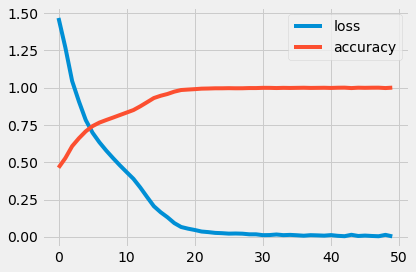

In [70]:
plt.style.use('fivethirtyeight')

plt.plot(range(len(loss)), loss, label='loss')
plt.plot(range(len(accuracy)), accuracy, label='accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Model Saving

In [71]:
# full_model.save('../../../RepositoryData/output/seq2seq-attention-addition/full-model.h5')
# infer_enc_model.save('../../../RepositoryData/output/seq2seq-attention-addition/infer-enc-model.h5')
# infer_dec_model.save('../../../RepositoryData/output/seq2seq-attention-addition/infer-dec-model.h5')

### Prediction

In [ ]:
full_model.load_weights('../../../RepositoryData/output/seq2seq-attention-addition/full-model.h5')
infer_enc_model.load_weights('../../../RepositoryData/output/seq2seq-attention-addition/infer-enc-model.h5')
infer_dec_model.load_weights('../../../RepositoryData/output/seq2seq-attention-addition/infer-dec-model.h5')

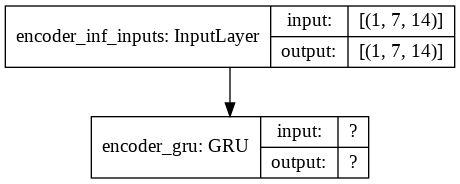

In [72]:
plot_model(infer_enc_model,show_shapes=True)

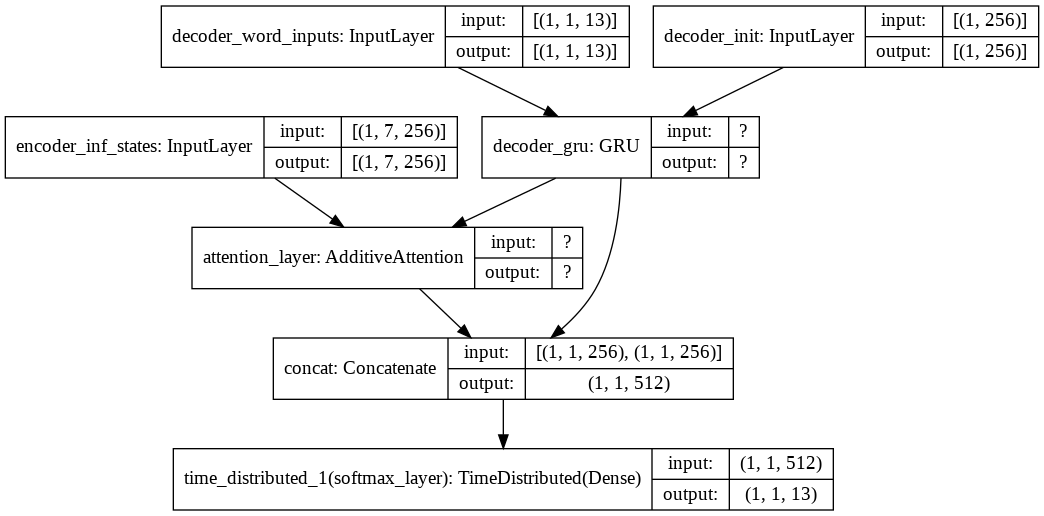

In [73]:
plot_model(infer_dec_model, show_shapes=True)

In [74]:
""" Index2word """
enc_index2word = dict(
    zip(enc_tokenizer.word_index.values(), enc_tokenizer.word_index.keys()))
dec_index2word = dict(
    zip(dec_tokenizer.word_index.values(), dec_tokenizer.word_index.keys()))


In [75]:
def translate(infer_enc_model, infer_dec_model, test_enc_text, 
              enc_vsize, dec_vsize, enc_timesteps, dec_timesteps,
              enc_tokenizer, dec_tokenizer):
    """ Inferring with trained model """
    test_enc = test_enc_text
    print('Translating: {}'.format(test_enc))

    test_enc_seq = sents2sequences(
        enc_tokenizer, [test_enc], pad_length=enc_timesteps)

    test_dec, attn_weights = infer_nmt(
        encoder_model=infer_enc_model, decoder_model=infer_dec_model,
        test_enc_seq=test_enc_seq, enc_vsize=enc_vsize, dec_vsize=dec_vsize, dec_timesteps = dec_timesteps)
    print('\tFrench: {}'.format(test_dec))
    return test_enc_seq, test_dec, attn_weights

In [76]:
test_enc_seq, test_dec, attn_weights=translate(infer_enc_model=infer_enc_model,
          infer_dec_model=infer_dec_model,
          test_enc_text=ts_enc_text[120],
          enc_vsize=enc_vsize,
          dec_vsize=dec_vsize,
          enc_timesteps=enc_timesteps,
          dec_timesteps=dec_timesteps,
          enc_tokenizer=enc_tokenizer,
          dec_tokenizer=dec_tokenizer)



Translating: 406+77 
	French: 483_


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


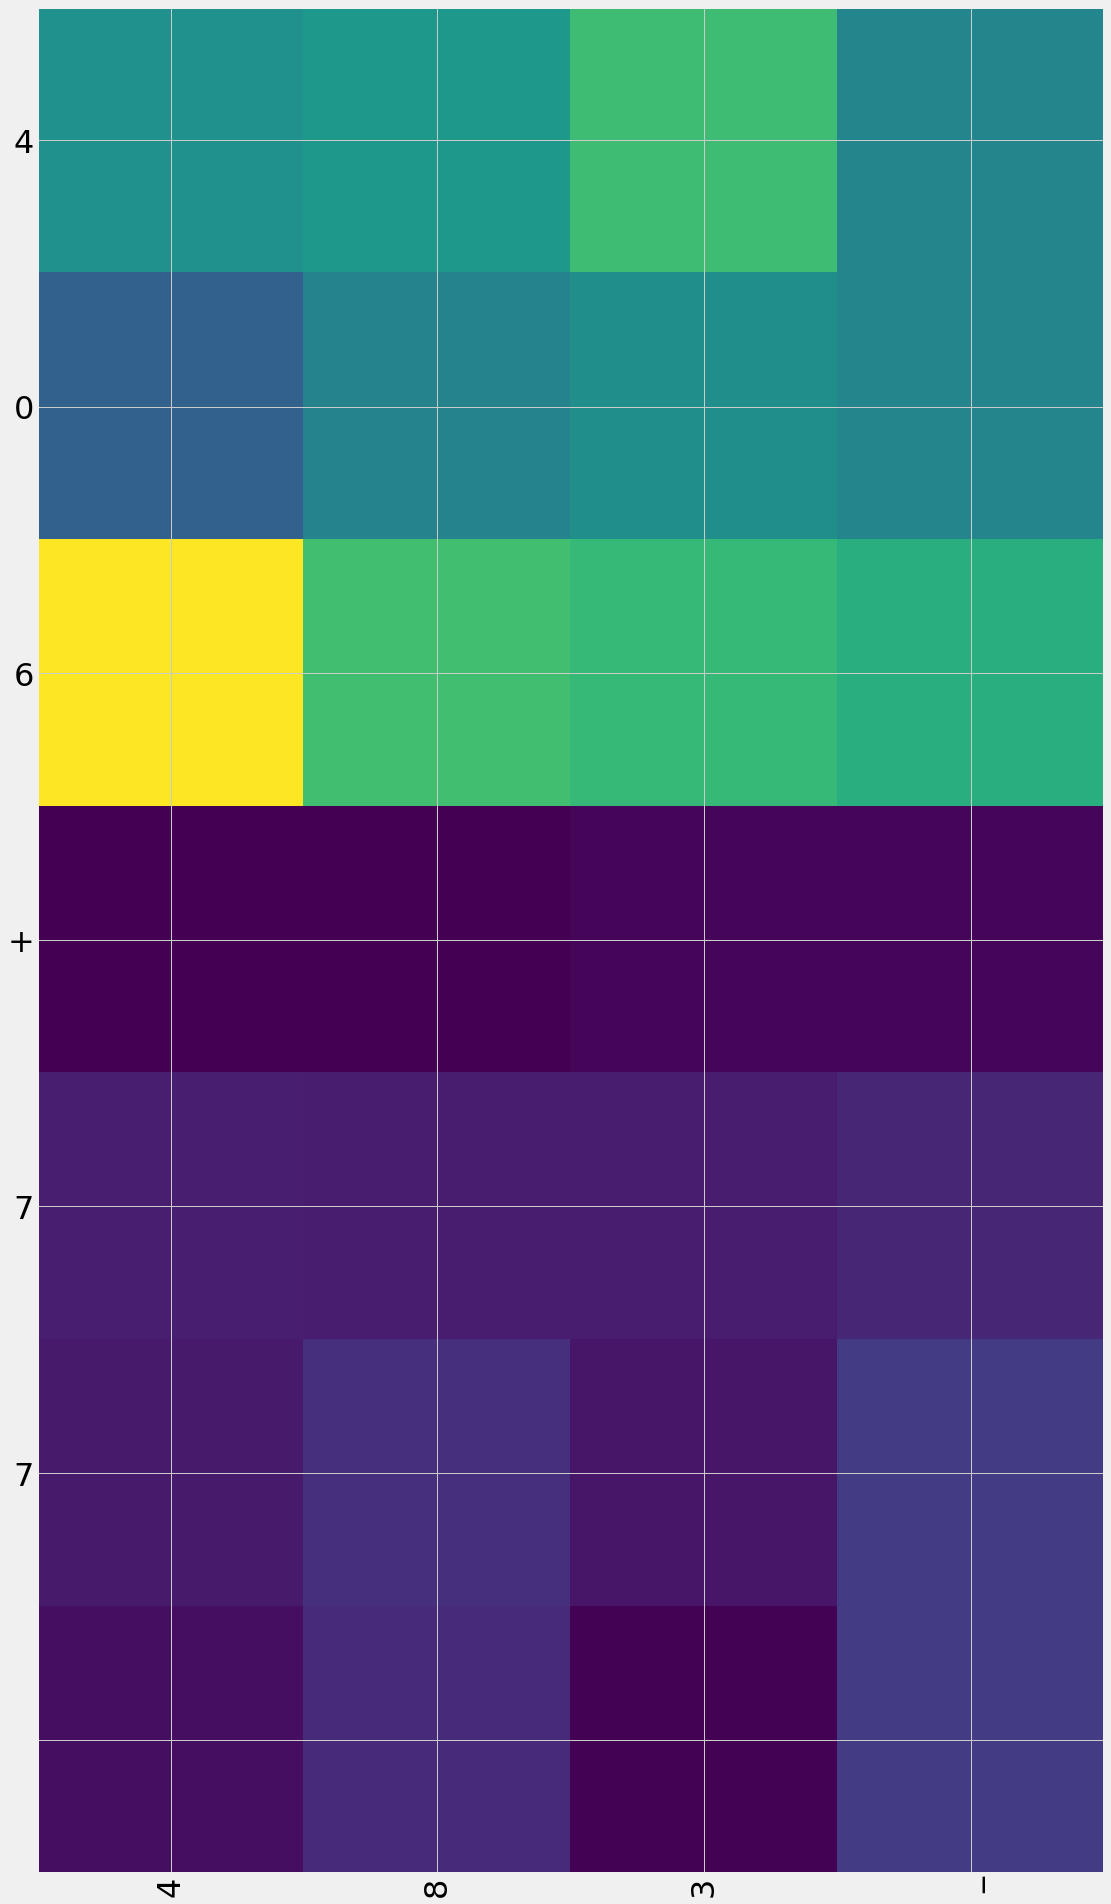

In [77]:
""" Attention plotting """
plot_attention_weights(test_enc_seq, attn_weights,
                       enc_index2word, dec_index2word)

In [ ]:

print(tr_enc_text[:5])
print(tr_dec_text[:5])



['27+673 ', '153+27 ', '93+901 ', '243+678', '269+46 ']
['_700_', '_180_', '_994_', '_921_', '_315_']


## Evaluation on Test Data

In [78]:
def test(full_model, ts_enc_text, ts_dec_text, enc_tokenizer, dec_tokenizer, batch_size):
    # ### Getting sequence integer data
    ts_enc_seq, ts_dec_seq = preprocess_data(enc_tokenizer, dec_tokenizer, ts_enc_text, ts_dec_text)
    losses = []
    accuracies = []
    for bi in range(0, ts_enc_seq.shape[0] - batch_size, batch_size):
        enc_onehot_seq = to_categorical(
            ts_enc_seq[bi:bi + batch_size, :], num_classes=enc_vsize)
        dec_onehot_seq = to_categorical(
            ts_dec_seq[bi:bi + batch_size, :], num_classes=dec_vsize)

        # full_model.train_on_batch(
        #     [enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :])
        l,a = full_model.evaluate([enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :],
                                batch_size=batch_size, verbose=0)
        losses.append(l)
        accuracies.append(a)
    print('Average Loss:{}'.format(np.mean(losses)))
    print('Average Accuracy:{}'.format(np.mean(accuracies)))

test(full_model, ts_enc_text = ts_enc_text, ts_dec_text = ts_dec_text, 
     enc_tokenizer = enc_tokenizer, dec_tokenizer = dec_tokenizer, batch_size = batch_size)

Average Loss:0.0022864048634562905
Average Accuracy:0.9996527823967132
